In [1]:
import numpy as np
import random
import pickle
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
start_t = time.time()

In [4]:
pkl_file = open('/content/drive/MyDrive/data/ucpd_vol.pkl', 'rb')
ucpd_vol = pickle.load(pkl_file)
pkl_file.close()

features = ['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high'] # ucpd_vol[:,:,:,0:6]

# Windows

In [5]:

def draw_windows(draws = 100, dim = 16, min_events = 10, ucpd_vol = ucpd_vol):


    ucpd_vol_count = np.count_nonzero(ucpd_vol[:,:,:,4], axis = 0)
    nonzero = np.where(ucpd_vol_count >= min_events) # number of events so >= 1 or >0 is the same as np.nonzero

    nonzero_row = nonzero[0]
    nonzero_col = nonzero[1]

    nonzero_coord = [(row, col) for row, col in zip(nonzero_row, nonzero_col)]
    
    h = ucpd_vol.shape[1]
    w = ucpd_vol.shape[2]
    
    sub_images_y = []
    sub_images_x = []
    
    for i in range(draws):
    
        coord = random.choice(nonzero_coord)

        new_y = np.random.randint(coord[0]-dim/2,coord[0]+dim/2)
        max_y = int(new_y + (dim/2))
        min_y = int(new_y - (dim/2))

        new_x = np.random.randint(coord[1]-dim/2,coord[1]+dim/2)
        max_x =  int(new_x + (dim/2))
        min_x = int(new_x - (dim/2))

        sub_images_y.append((min_y,max_y))
        sub_images_x.append((min_x,max_x))
    
    return(sub_images_y,sub_images_x)
    

# Unet

DONE: Normaization and standardization did not seem to do any good at all..

DONE: Dropout and random rotation implimented - works great.

Tried: Current state

Don: Ensample or variational


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# giev everything better names at some point
class UNet(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, dropout_rate):
        super().__init__()

        base = hidden_channels # ends up as hiddden channels
        self.base = base # to extract later
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(input_channels + hidden_channels, base, 3, padding=1) # but then with hidden_c you go from 65 to 64...
        self.pool0 = nn.MaxPool2d(2, 2, padding=0) 

        self.enc_conv1 = nn.Conv2d(base, base*2, 3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2, padding=0) # 8 -> 4

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(base*2, base*4, 3, padding=1)
        
        self.upsample0 = nn.ConvTranspose2d(base*4, base*2, 2, stride= 2, padding= 0, output_padding= 0) # 4 -> 8
        self.dec_conv0 = nn.Conv2d(base*4, base*2, 3, padding=1) # base+base=base*2 because of skip conneciton
        
        self.mu_d0_conv = nn.Conv2d(base*2, base*2, 3, padding=1)
        self.sigma_d0_conv = nn.Conv2d(base*2, base*2, 3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(base*2, base, 2, stride= 2, padding= 0, output_padding= 0) # 8 -> 16
        self.dec_conv1 = nn.Conv2d(base*2, base, 3, padding=1) # base+base=base*2 because of skip connection

        self.dec_conv2 = nn.Conv2d(base, output_channels, 3, padding=1) 

        # misc
        self.dropout = nn.Dropout(p = dropout_rate)

    def reparameterize(self, mu, log_var):

        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        
        return sample


    def forward(self, x, h):
        
        x = torch.cat([x, h], 1)

        # encoder
        e0s = F.relu(self.enc_conv0(x))
        e0 = self.pool0(self.dropout(e0s))
        
        e1s = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(self.dropout(e1s))
        

        # bottleneck
        b = F.relu(self.bottleneck_conv(e1))
        b = self.dropout(b)

        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b),e1s],1)))
        
        d0_mu = torch.tanh(self.mu_d0_conv(d0))
        d0_sigma = F.relu(self.sigma_d0_conv(d0))
        d0 = self.reparameterize(d0_mu, d0_sigma)

        d0 = self.dropout(d0)


        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e0s],1)))  # You did not have any activations before - why not?
        d1 = self.dropout(d1)

        d2 = self.dec_conv2(d1) # test bc I don't want negative values...
        
        return d2, e0s, d0_mu, d0_sigma # e0s here also hidden state - should take tanh of self.enc_conv0(x) but it does not appear to make a big difference....

    def init_h(self, hidden_channels = 64, dim = 16): # could have x as input and then take x.shape

        return torch.zeros((1,hidden_channels,dim,dim), dtype= torch.float64) # the dims could just be infered... sp you donøt needd to funct or change if w siae changes.

    def init_hTtime(self, hidden_channels = 64):

        return torch.zeros((1,hidden_channels,360,720), dtype= torch.float64)

# Training

In [8]:
def final_loss(mce_loss, mu, logvar):

    MCE = mce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MCE + KLD

In [9]:

def train(model, optimizer, criterion, input_tensor, plot = False):
    
    avg_loss = 0

    model.train()  # train mode
    
    seq_len = input_tensor.shape[1] 
    window_dim = input_tensor.shape[2]
    
    h = unet.init_h(hidden_channels = model.base, dim = window_dim).float().to(device)

    for i in range(seq_len-1): # so your sequnce is the full time len
         
        t0 = input_tensor[:, i, :, :].reshape(1, 1 , window_dim , window_dim).to(device) 
        t1 = input_tensor[:, i+1, :, :].reshape(1, 1 , window_dim, window_dim).to(device)

        # forward
        t1_pred, h, b_mu, b_sigma = model(t0, h)


    # backwards    
    optimizer.zero_grad()
    # loss = criterion(t1, t1_pred)  # forward-pass
    
    mse_loss = criterion(t1, t1_pred)  # forward-pass
    loss = final_loss(mse_loss, b_mu, b_sigma)  # forward-pass

    loss.backward()  # backward-pass
    optimizer.step()  # update weights
        
    # Reporting 
    avg_loss += loss / (seq_len-1)

    return(avg_loss)

In [10]:
# Split of train. leaving the last year as a training year. 
# Thus I do not create a individual test as that isjust the original set: still including the last year.

train_ucpd_vol = ucpd_vol[:-1] # all except the last year
print(train_ucpd_vol.shape)

(30, 360, 720, 7)


In [11]:
hidden_channels = 64
input_channels = 1
output_channels = 1
dropout_rate = 0.8

unet = UNet(input_channels, hidden_channels, output_channels, dropout_rate).to(device)

learning_rate = 0.0001
weight_decay = 0.01
optimizer = torch.optim.Adam(unet.parameters(), lr = learning_rate, weight_decay = weight_decay)

criterion = nn.MSELoss().to(device)
# criterion =  nn.L1Loss().to(device)
# criterion = nn.SmoothL1Loss().to(device) # actually very good on long runs


draws = 2000 # same as draws..
avg_losses = []

dim = 16 # 32 and 64 gives similar results - maybe ever so slightly better. 8 is a bit worse. 
seq_len = train_ucpd_vol.shape[0]

# Get sub_image
sub_images_y,sub_images_x = draw_windows(draws = draws, dim = dim, min_events = 5, ucpd_vol = ucpd_vol) # right now can only be 16 becasue of def init_he0s(self):

# data augmentation
transformer = transforms.Compose([transforms.RandomRotation((0,360)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])


for i in range(draws):

    input_tensor = torch.tensor(train_ucpd_vol[:, sub_images_y[i][0]:sub_images_y[i][1], sub_images_x[i][0]:sub_images_x[i][1], 4].reshape(1, seq_len, dim, dim)).float() #Why not do this in funciton?
    
    # data augmentation (can be turned of for final experiments)
    input_tensor = transformer(input_tensor) # rotations and flips

    avg_loss = train(unet, optimizer, criterion, input_tensor, plot = False)
    avg_losses.append(avg_loss)

    
    if i % 100 == 0: # print steps 100
        print(f'{i} {avg_loss:.4f}')


0 0.0705
100 0.0061
200 0.0088
300 0.0804
400 0.0021
500 0.0509
600 0.0867
700 0.0003
800 0.0256
900 0.0015
1000 0.0365
1100 0.0414
1200 0.0001
1300 0.0376
1400 0.0449
1500 0.0612
1600 0.0008
1700 0.0188
1800 0.0116
1900 0.0306


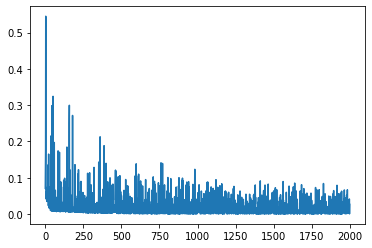

In [12]:
plt.figure()
plt.plot(avg_losses)
plt.show()

# Evaluation:

In [13]:
def test(model, input_tensor):
  model.eval() # remove to allow dropout to do its thing as a poor mans ensamble. but you need a high dropout..
  # but there was also something else that you neede to acount for when doing this..?

  h_tt = unet.init_hTtime(hidden_channels = model.base).float().to(device)
  seq_len = input_tensor.shape[1] 
  H = input_tensor.shape[2]
  W = input_tensor.shape[3] 

  for i in range(seq_len-1): # need to get hidden state...

    t0 = input_tensor[:, i, :, :].reshape(1, 1 , H , W).to(device) 
    t1 = input_tensor[:, i+1, :, :].reshape(1, 1 , H, W).to(device)

    t1_pred, h_tt, _, _ = unet(t0, h_tt)

  tn_pred_np = t1_pred.cpu().detach().numpy() # so yuo take the final pred..

  return tn_pred_np

In [14]:
ttime_tensor = torch.tensor(ucpd_vol[:, :, : , 4].reshape(1, 31, 360, 720)).float().to(device) #Why not do this in funciton?
t31_pred_np = test(unet, ttime_tensor)

print((t31_pred_np < 0).mean()) # Check for sub-zero predictions
print(t31_pred_np.reshape(-1)[t31_pred_np.reshape(-1)>0].min()) # min val over zero
print(ucpd_vol[30,:,:,4].reshape(-1)[ucpd_vol[30,:,:,4].reshape(-1)>0].min()) # min val over 0

8.873456790123456e-05
0.0002378244
0.6931471805599453


In [15]:
ttime_tensor = torch.tensor(ucpd_vol[:, :, : , 4].reshape(1, 31, 360, 720)).float().to(device) #Why not do this in funciton?
pred_list = []
n=1000

for i in range(n):
  t31_pred_np = test(unet, ttime_tensor)
  pred_list.append(t31_pred_np)

  if i % 100 == 0: # print steps 100
      print(f'{i}')

t31_pred_np = np.array(pred_list)

0
100
200
300
400
500
600
700
800
900


In [16]:
t31_pred_np_mean = t31_pred_np.mean(axis=0)
print(t31_pred_np.min(), t31_pred_np.max())

-0.049462013 6.6619277


In [17]:
t31_pred_np_std = t31_pred_np.std(axis=0)
print(t31_pred_np_std.min(), t31_pred_np_std.max())

0.0018089646 0.038478695


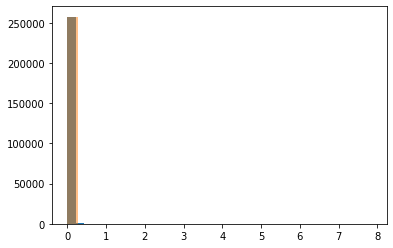

In [18]:
plt.hist(t31_pred_np_mean.reshape(-1), bins= 30)
plt.hist(ucpd_vol[30,:,:,4].reshape(-1), bins= 30, alpha = 0.5)

plt.show()
# So both have alot of zeros and we capture that

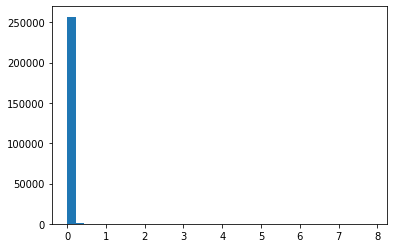

In [19]:
plt.hist(t31_pred_np_mean.reshape(-1)[t31_pred_np_mean.reshape(-1)>0], bins= 30)
plt.hist(ucpd_vol[30,:,:,4].reshape(-1)[ucpd_vol[30,:,:,4].reshape(-1)>0], bins= 30, alpha = 0.5)

plt.show()
# so distrbutions very defferent above zero bc predctions have a lot of very small values just above zero

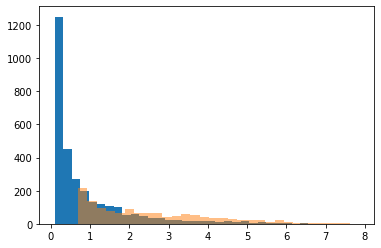

In [20]:
plt.hist(t31_pred_np_mean.reshape(-1)[t31_pred_np_mean.reshape(-1)>0.1], bins= 30)
plt.hist(ucpd_vol[30,:,:,4].reshape(-1)[ucpd_vol[30,:,:,4].reshape(-1)>0.1], bins= 30, alpha = 0.5)

plt.show()
# so distrbutions pretty defferent above 0.1 bc predctions have a lot of very small values just above zero
# A zero inflated model might help here..

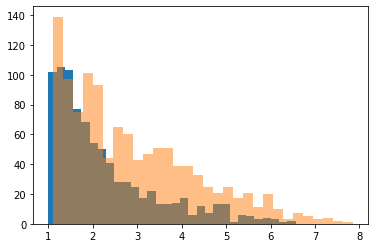

In [21]:
plt.hist(t31_pred_np_mean.reshape(-1)[t31_pred_np_mean.reshape(-1)>=1], bins= 30)
plt.hist(ucpd_vol[30,:,:,4].reshape(-1)[ucpd_vol[30,:,:,4].reshape(-1)>=1], bins= 30, alpha = 0.5)

plt.show()
# Distrbutions pretty similar from 1 and above 1 though. But predictions are still to conservative.., but setting a high number for conflicts in windows helps

In [22]:
t31_pred_np_mean = np.maximum(t31_pred_np_mean,0) # relu to prevent sub zeroes.. it does almost no differnece when you have the variational layar.

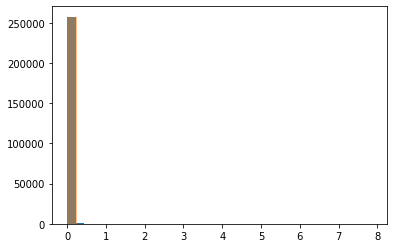

In [23]:
plt.hist(t31_pred_np_mean.reshape(-1), bins= 30)
plt.hist(ucpd_vol[30,:,:,4].reshape(-1), bins= 30, alpha = 0.5)

plt.show()
# The relu helps a bit with the distribution

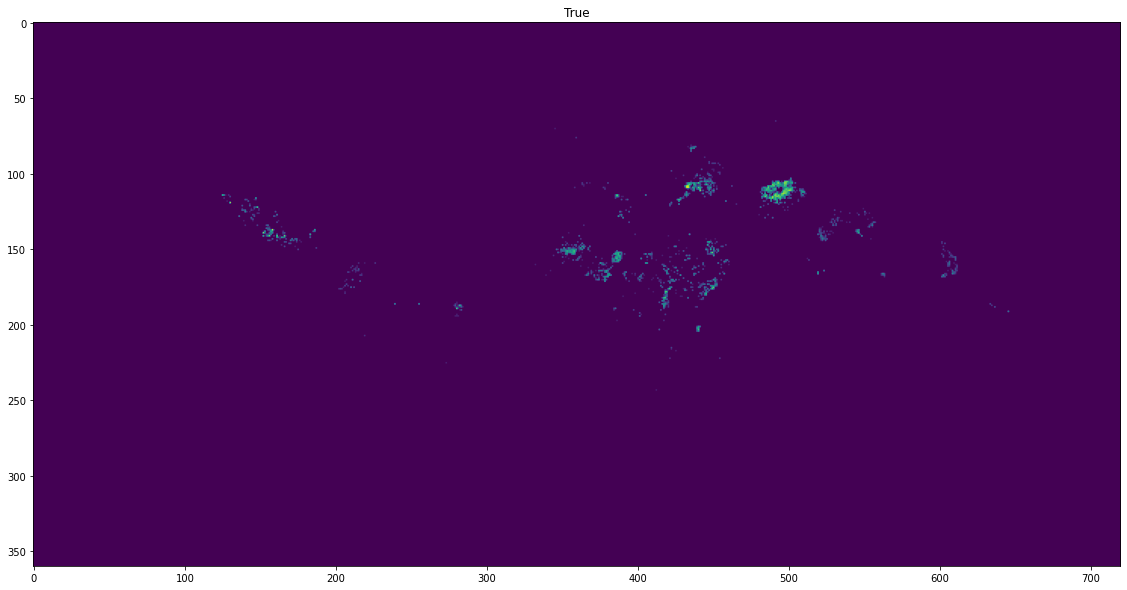

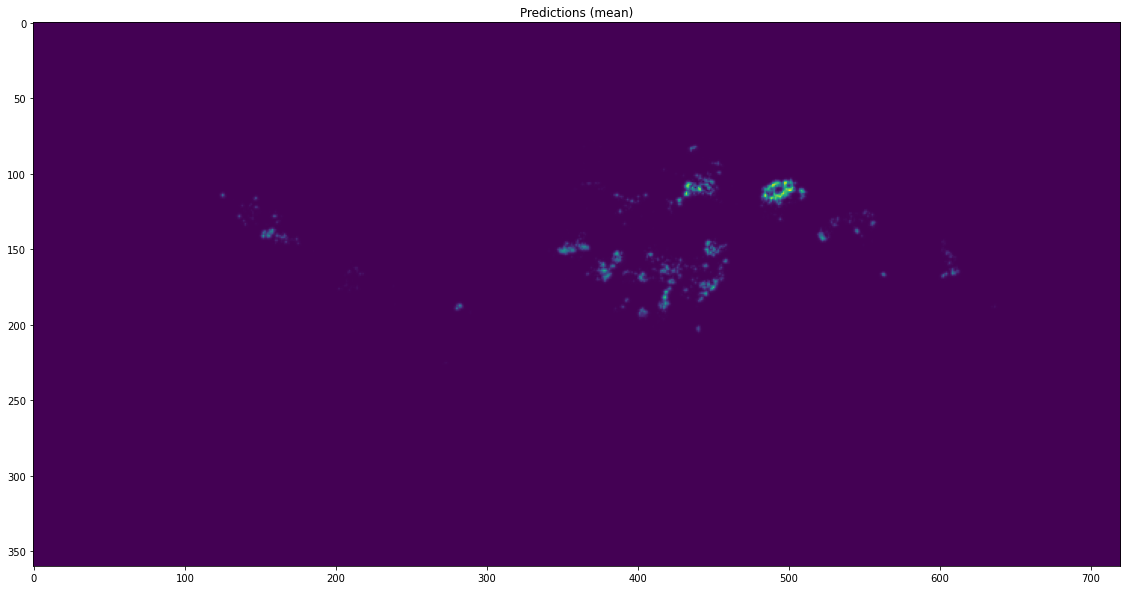

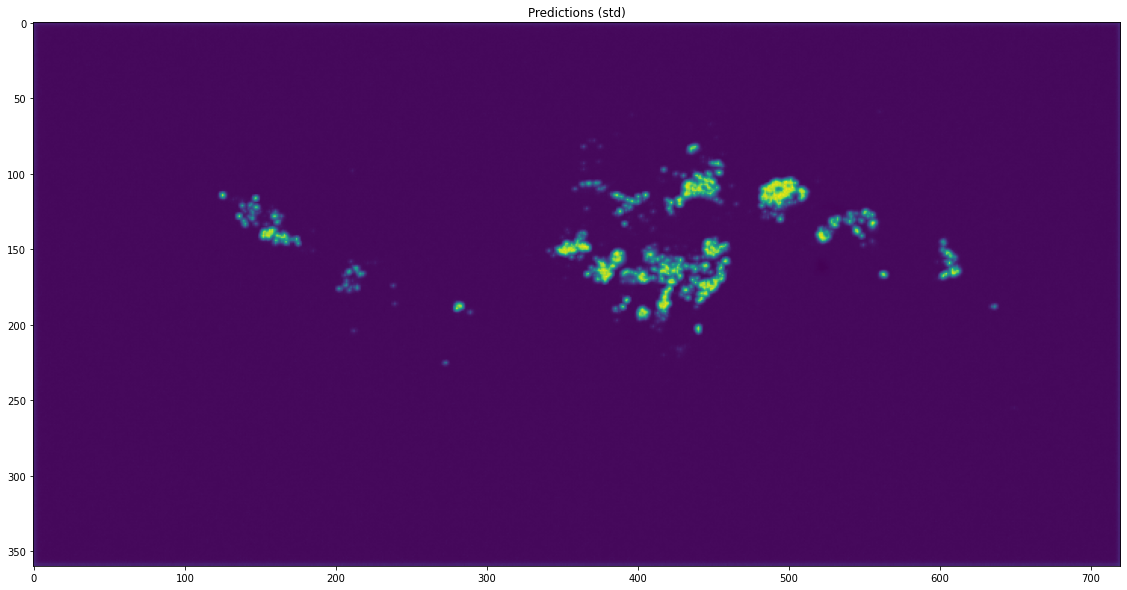

0.0 6.564178
0.0 7.851661177889265


In [24]:
plt.figure(figsize=(20,10))
plt.imshow(ucpd_vol[30,:,:,4])
plt.title('True')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(t31_pred_np_mean[0,0,:,:])
plt.title('Predictions (mean)')
plt.show()

t31_pred_np.shape            
plt.figure(figsize=(20,10))
plt.imshow(t31_pred_np_std[0,0,:,:])
plt.title('Predictions (std)')
plt.show()

print(t31_pred_np_mean.min(),t31_pred_np_mean.max())
print(ucpd_vol[30,:,:,4].min(),ucpd_vol[30,:,:,4].max())

In [25]:
def my_sigmoid(x):
    s  = 1/(1 + np.e **(-x))
    return(s)

y_score = t31_pred_np_mean.reshape(360*720)
y_score_prob = my_sigmoid(y_score)

y_true = ucpd_vol[30,:,:,4].reshape(360*720)
y_true_binary = (y_true > 0) * 1

print('Unet')

print(mean_squared_error(y_true, y_score))
print(average_precision_score(y_true_binary, y_score_prob))
print(roc_auc_score(y_true_binary, y_score_prob))
print(brier_score_loss(y_true_binary, y_score_prob))

Unet
0.01900006325600514
0.6481291265561657
0.9743586930469872
0.25509219967478175


In [26]:
persitance_baseline = ucpd_vol[29,:,:,4].reshape(360*720)
persitance_baseline_prob = my_sigmoid(persitance_baseline)
# persitance_baseline_prob = (persitance_baseline > 0) * 1 # alt persitance. Better brier but worse everything else


print('Persitance baseline')

print(mean_squared_error(y_true, persitance_baseline))
print(average_precision_score(y_true_binary, persitance_baseline_prob))
print(roc_auc_score(y_true_binary, persitance_baseline_prob))
print(brier_score_loss(y_true_binary, persitance_baseline_prob))

Persitance baseline
0.023701174962203957
0.49879392072819045
0.8024039061787233
0.2501474921559414


In [27]:
file_name = "/content/drive/MyDrive/data/t31_pred_np.pkl"
output = open(file_name, 'wb')
pickle.dump(t31_pred_np, output)
output.close()

#avg_losses

In [28]:
end_t = time.time()
minutes = (end_t - start_t)/60

print(f'Done. Runtime: {minutes:.3f} minutes')

Done. Runtime: 23.832 minutes
